In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as d
import datetime
import pandas as pd
from pathlib import Path
# %matplotlib tk

In [2]:
measure_path = Path("/media/t/Bachelor/videos/29-03/temperature-29-03-21-08-15-39.csv")
count_paths = [Path("/media/t/Bachelor/videos/29-03/log_vid_29-03-0818.csv"),
               Path("/media/t/Bachelor/videos/29-03/log_vid_29-03-1321.csv"),
               Path("/media/t/Bachelor/videos/29-03/log_vid_29-03-1923.csv")]

# count_paths = [Path("/media/t/Bachelor/videos/30-03/log_vid3003.csv")]

li = []
for filename in count_paths:
    df = pd.read_csv(filename, index_col=None, names=['Time', 'In', 'Out'])
    print(len(df))
    li.append(df)

count_df = pd.concat(li, axis=0, ignore_index=True)
measure_df = pd.read_csv(measure_path)
measure_df = measure_df.dropna()

1084746
1301461
165196


In [3]:
# Weather from station
station = pd.read_csv("/media/t/Bachelor/videos/30-03/Wetterdaten-2020-10-01--2021-04-11.csv", delimiter=';',
                      skiprows=[1,2], header=0, thousands=',')
station['Datum'] = pd.to_datetime(station['Datum'], format="%d.%m.%y %H:%M")
print(station)

                    Datum  Temperatur innen  Luftfeuchte innen Luftdruck  \
0     2020-10-01 00:04:00              2030               5300    973,00   
1     2020-10-01 00:09:00              2040               5300    973,00   
2     2020-10-01 00:14:00              2040               5300    973,00   
3     2020-10-01 00:19:00              2040               5300    973,00   
4     2020-10-01 00:24:00              2040               5300    973,00   
...                   ...               ...                ...       ...   
55513 2021-04-11 22:42:00              2110               3500    978,00   
55514 2021-04-11 22:47:00              2120               3500    978,00   
55515 2021-04-11 22:52:00              2120               3500    978,00   
55516 2021-04-11 22:57:00              2120               3500    978,00   
55517 2021-04-11 23:02:00              2130               3500    978,00   

       Temperatur aussen  Luftfeuchte aussen  Niederschlag  \
0                 1070.0 

Handle Time

In [4]:
grouped = 1
frames_per_second = 60
start_time = datetime.datetime(day=29, month=3, year=2021, hour=8, minute=18)
start_day = start_time.date()
duration = datetime.timedelta(seconds=count_df.shape[0] / 60 * grouped)
end_time = start_time + duration
print("Starting at: {0}\nEnding at: {1}\nDuration: {2}".format(start_time, end_time, duration))

measure_df['Time']= pd.to_datetime(measure_df['Time'], format='%H:%M:%S').dt.time
measure_df['Time'] = measure_df['Time'].apply(lambda x: datetime.datetime.combine(start_day, x))
measure_df = measure_df[(measure_df['Time'] >= start_time) & (measure_df['Time'] < end_time)]

count_df['Time'] = start_time + np.arange(len(count_df)) * datetime.timedelta(seconds=1 / frames_per_second * grouped)

station = station[(station['Datum'] >= start_time) & (station['Datum'] <= end_time + datetime.timedelta(minutes=12))]

Starting at: 2021-03-29 08:18:00
Ending at: 2021-03-29 20:06:43.383333
Duration: 11:48:43.383333


In [5]:
total_in, total_out = count_df['In'].sum(), count_df['Out'].sum()
print("In: {0:,} Out: {1:,} Diff: {2:,}".format(total_in, total_out, abs(total_in - total_out)))
# In: 296,530 Out: 247,846 Diff: 48,684

In: 296,530 Out: 247,846 Diff: 48,684


In [8]:
r1 = (datetime.datetime(day=30, month=3, year=2021, hour=10, minute=00)  - start_time).seconds * 60
r2 = (datetime.datetime(day=30, month=3, year=2021, hour=15, minute=00)  - start_time).seconds * 60
np.random.seed(0)
stellen = np.random.choice(np.arange(r1, r2, 1), size=(50000, ))
# modified_out = count_df['Out'].copy()
modified_in = count_df['In'].copy()
for i in stellen:
    modified_in[i] -= 1

In [9]:
group_size = 4000
# in_data = count_df['In'].groupby(count_df.index // group_size).sum()
in_data = modified_in.groupby(modified_in.index // group_size).sum()
out_data = count_df['Out'].groupby(count_df.index // group_size).sum()
count_date = count_df['Time'].groupby(count_df.index // group_size).min()

measure_group = 100
temperature_data = measure_df['Temperature'].groupby(measure_df.index // measure_group).mean()
pressure_data = measure_df['Pressure'].groupby(measure_df.index // measure_group).mean()
measure_date = measure_df['Time'].groupby(measure_df.index // measure_group).min()

station_group = 2
station_temperature = (station['Temperatur aussen'] / 100).groupby(station.index // station_group).mean()
station_hum = (station['Luftfeuchte aussen'] / 100).groupby(station.index // station_group).mean()
station_date = station['Datum'].groupby(station.index // station_group).min()

Plot

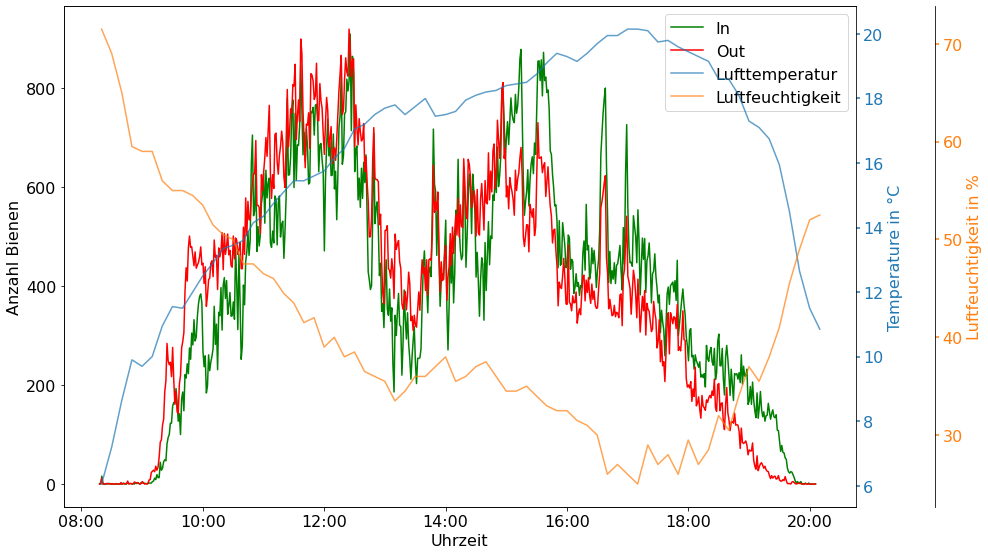

In [12]:
plt.style.use({'figure.facecolor':'white'})
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(14,8))
temperature_ax = ax.twinx()
pressure_ax = ax.twinx()

myFmt = d.DateFormatter('%H:%M')

pressure_ax.spines["right"].set_position(("axes", 1.1))
ax.set_frame_on(True)
ax.patch.set_visible(False)
for sp in ax.spines.values():
    sp.set_visible(False)
pressure_ax.spines["right"].set_visible(True)

in_plt = ax.plot(count_date, in_data, 'g-', label='In')
out_plt = ax.plot(count_date, out_data, 'r-', label='Out')
ax.xaxis.set_major_formatter(myFmt)

temp_plt = temperature_ax.plot(station_date, station_temperature, '#1f77b4', label="Lufttemperatur", alpha=0.7)
# temperature_ax.plot(measure_date, temperature_data, 'pink', label="Lufttemperatur", alpha=0.7)
pre_plt = pressure_ax.plot(station_date, station_hum, '#ff7f0e', label="Luftfeuchtigkeit", alpha=0.7)
temperature_ax.xaxis.set_major_formatter(myFmt)

ax.set_xlabel("Uhrzeit")
ax.set_ylabel("Anzahl Bienen")
temperature_ax.set_ylabel("Temperature in °C")
pressure_ax.set_ylabel("Luftfeuchtigkeit in %")

temperature_ax.yaxis.label.set_color(temp_plt[0].get_color())
pressure_ax.yaxis.label.set_color(pre_plt[0].get_color())
tkw = dict(size=4, width=1.5)
temperature_ax.tick_params(axis='y', colors=temp_plt[0].get_color(), **tkw)
pressure_ax.tick_params(axis='y', colors=pre_plt[0].get_color(), **tkw)

lines = [in_plt[0], out_plt[0], temp_plt[0], pre_plt[0]]
ax.legend(lines, [l.get_label() for l in lines])

fig.tight_layout()
fig.savefig('summary_count_2903.png', dpi=300)
# plt.show()

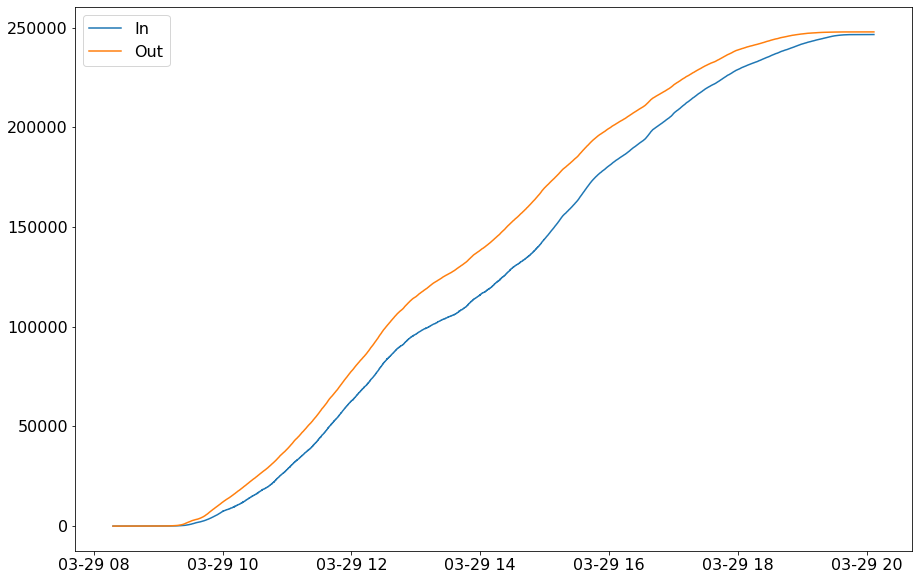

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
in_plt = ax.plot(count_df['Time'], modified_in.cumsum(), label='In')
out_plt = ax.plot(count_df['Time'], count_df['Out'].cumsum(), label='Out')
plt.legend()
plt.show()